In [28]:
import numpy as np 
from matplotlib import cm 
import matplotlib.pyplot as plt 

%matplotlib inline

In [3]:
np.random.seed(seed=1)

# Create dataset

In [4]:
nb_of_samples = 20
sequence_len = 10

# Create the sequences

In [5]:
X = np.zeros((nb_of_samples, sequence_len))
for row_idx in range(nb_of_samples):
    X[row_idx,:] = np.around(np.random.rand(sequence_len)).astype(int)

# Create the targets for each sequence

In [6]:
t = np.sum(X, axis=1)

# Function for the forward step

In [7]:
def update_state(xk, sk, wx, wRec):
    """
    Compute state k from the previous state (sk) and current input (xk),
    by use of the input weights (wx) and recursive weights (wRec).
    """
    return xk * wx + sk * wRec

In [8]:
def forward_states(X, wx, wRec):
    """
    Compute all state activations given the input X, input weights (wx) and recursive weights (wRec).
    """

    S = np.zeros((X.shape[0], X.shape[1] + 1))
    for k in range(0, X.shape[1]):
        # S[k] = S[k-1] * wRec + X[k] * wx
        S[:,k+1] = update_state(X[:,k], S[:,k], wx, wRec)
    return S

In [9]:
def cost(y, t): 
    """
    Return the MSE between the targets t and the outputs y.
    """
    return ((t - y)**2).sum() / nb_of_samples

In [10]:
def output_gradient(y, t):
    """
    Compute the gradient of the MSE cost function with respect to the output y.
    """
    return 2.0 * (y - t) / nb_of_samples

# Function for the Backward gradient

In [11]:
def backward_gradient(X, S, grad_out, wRec):
    """
    Backpropagate the gradient computed at the output (grad_out) through the network.
    Accumulate the parameter gradients for wX and wRec for each layer by addition.
    Return the parameter gradients at the output of each layer.
    """
    # Initialise the array that stores the gradients of the cost with respect to the states.
    grad_over_time = np.zeros((X.shape[0], X.shape[1]+1))
    grad_over_time[:,-1] = grad_out
    # Set the gradient accumulations to 0
    wx_grad = 0
    wRec_grad = 0
    for k in range(X.shape[1], 0, -1):
        # Compute the parameter gradients and accumulate the results.
        wx_grad += np.sum(grad_over_time[:,k] * X[:,k-1])
        wRec_grad += np.sum(grad_over_time[:,k] * S[:,k-1])
        # Compute the gradient at the output of the previous layer
        grad_over_time[:,k-1] = grad_over_time[:,k] * wRec
    return (wx_grad, wRec_grad), grad_over_time

# Checking Gradient

In [18]:
wx = [0.6]
wRec= [0.1]

# Set the small change to compute the numerical gradient
eps = 1e-7

for i in range(0, len(wx)):
    # Compute the backprop gradients
    S = forward_states(X, wx[i], wRec)
    grad_out = output_gradient(S[:,-1], t)
    backprop_grads, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    # Compute the numerical gradient for each parameter in the layer
    grad_backprop = backprop_grads[i]
    # + eps
    wx[i] += eps
    plus_cost = cost(forward_states(X, wx[i], wRec)[:,-1], t)
    # - eps
    wx[i] -= 2 * eps
    min_cost = cost(forward_states(X, wx[i], wRec)[:,-1], t)
    # reset param value
    wx[i] += eps
    # calculate numerical gradient
    grad_num = (plus_cost - min_cost) / (2*eps)

# Define points to annotate (wx, wrec, color)

In [40]:
"""When wrec=0, gradient goes to 0 immediately and when wrec=1, the gradient remains constant over the time"""

points = [(0.6,0.05,'r'), (-0.5,0.01,'b'), (-0.2,0.1,'y')]

# Define plotting functions

In [36]:
def get_cost_surface(w1_low, w1_high, w2_low, w2_high, nb_of_ws, cost_func):
    """Define a vector of weights for which we want to plot the cost."""
    w1 = np.linspace(w1_low, w1_high, num=nb_of_ws)   # Weight 1
    w2 = np.linspace(w2_low, w2_high, num=nb_of_ws)   # Weight 2
    ws1, ws2 = np.meshgrid(w1, w2)                    # Generate grid
    cost_ws = np.zeros((nb_of_ws, nb_of_ws))          # Initialize cost matrix
    
    # Fill the cost matrix for each combination of weights
    for i in range(nb_of_ws):
        for j in range(nb_of_ws):
            cost_ws[i,j] = cost_func(ws1[i,j], ws2[i,j])
    return ws1, ws2, cost_ws

In [37]:
def plot_gradient_over_time(points, get_grad_over_time):
    """Plot the gradients of the annotated point and how the evolve over time."""
    fig = plt.figure(figsize=(6.5, 4))  
    ax = plt.subplot(111)
    # Plot points
    for wx, wRec, c in points:
        grad_over_time = get_grad_over_time(wx, wRec)
        x = np.arange(-grad_over_time.shape[1]+1, 1, 1)
        plt.plot(x, np.sum(grad_over_time, axis=0), c+'-', label='({0}, {1})'.format(wx, wRec), linewidth=1, markersize=8)
    plt.xlim(0, -grad_over_time.shape[1]+1)
    # Set up plot axis
    plt.xticks(x)
    plt.yscale('symlog')
    plt.yticks([10**4, 10**2, 0, -10**2, -10**4])
    plt.xlabel('Sample length', fontsize=14)
    plt.ylabel('$\\frac{\\partial \\xi}{\\partial S_{k}}$', fontsize=20, rotation=0)
    plt.grid()
    plt.title('Gradients changing by Backpropagation')
    # Set legend
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False, numpoints=1)
    leg.set_title('$(w_x, w_{rec})$', prop={'size':18})

In [38]:
def get_grad_over_time(wx, wRec):
    """Func to get the gradient over time from wx and wRec."""
    S = forward_states(X, wx, wRec)
    grad_out = output_gradient(S[:,-1], t).sum()
    _, grad_over_time = backward_gradient(X, S, grad_out, wRec)
    return grad_over_time

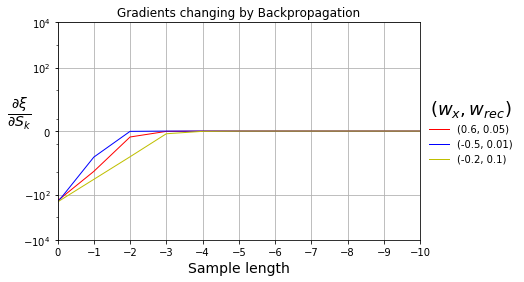

In [39]:
plot_gradient_over_time(points, get_grad_over_time)
plt.show()